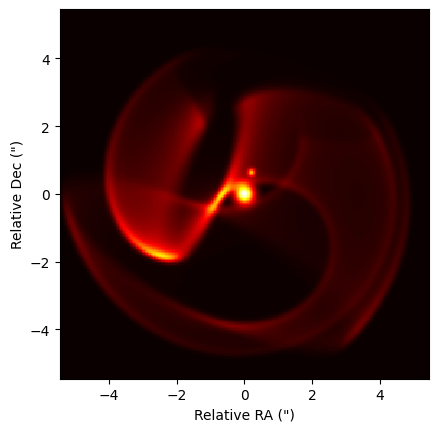

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
from glob import glob
import os
from astropy.io import fits

# pscale = 1000 * 23/512 # mas/pixel, (Yinuo's email said 45mas/px, but I think the FOV is 23x23 arcsec for a 512x512 image?)

import WR_Geom_Model as gm
import WR_binaries as wrb

# Start by analysing projection effects with the model

0.4


<AxesSubplot:xlabel='Relative RA (")', ylabel='Relative Dec (")'>

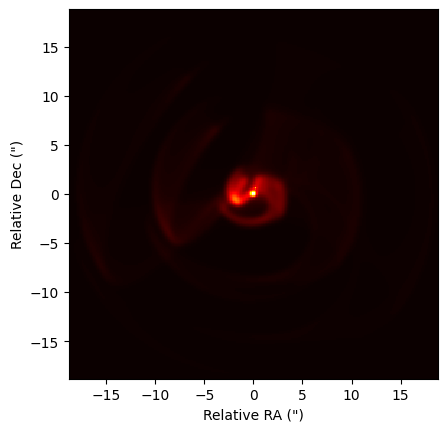

In [2]:
apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
apep['phase'] = 0.4
print(apep['phase'])
shells = 3
model_func = gm.gui_funcs[shells-1]

particles, weights = model_func(apep)
X, Y, H = gm.smooth_histogram2d(particles, weights, apep)
# print(time.time() - t1)
H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
gm.plot_spiral(X, Y, H)


### Left to right ridge shell evolution

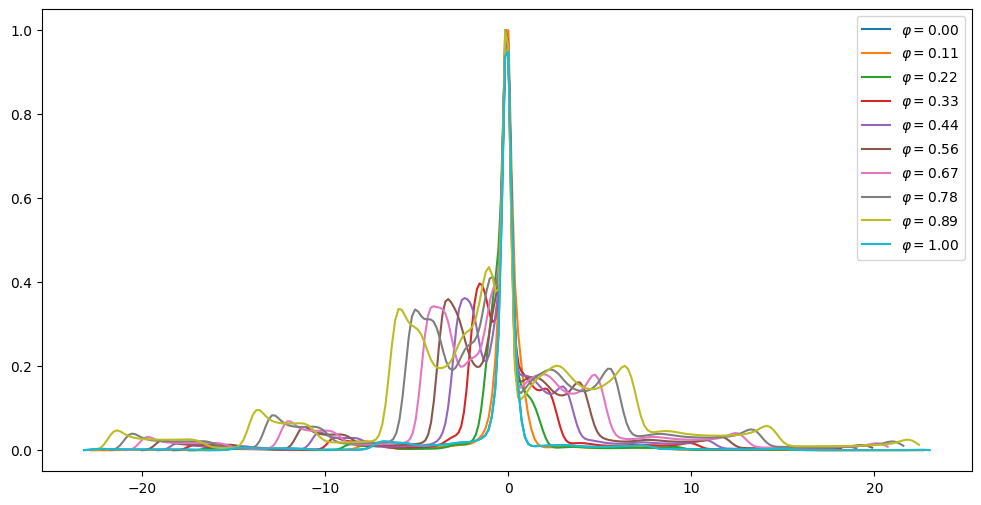

In [3]:
apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
# apep['phase'] = 0.6
shells = 3
model_func = gm.gui_funcs[shells-1]

fig, ax = plt.subplots(figsize=(12, 6))

for phase in np.linspace(0, 1, 10):
    apep['phase'] = phase
    particles, weights = model_func(apep)
    X, Y, H = gm.smooth_histogram2d(particles, weights, apep)
    # print(time.time() - t1)
    H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
#     gm.plot_spiral(X, Y, H)
    ax.plot(X[0, :-1], H[len(X[0, :])//2, :], label=fr'$\varphi = {phase:.2f}$')
ax.legend()

### Bottom to top shell evolution

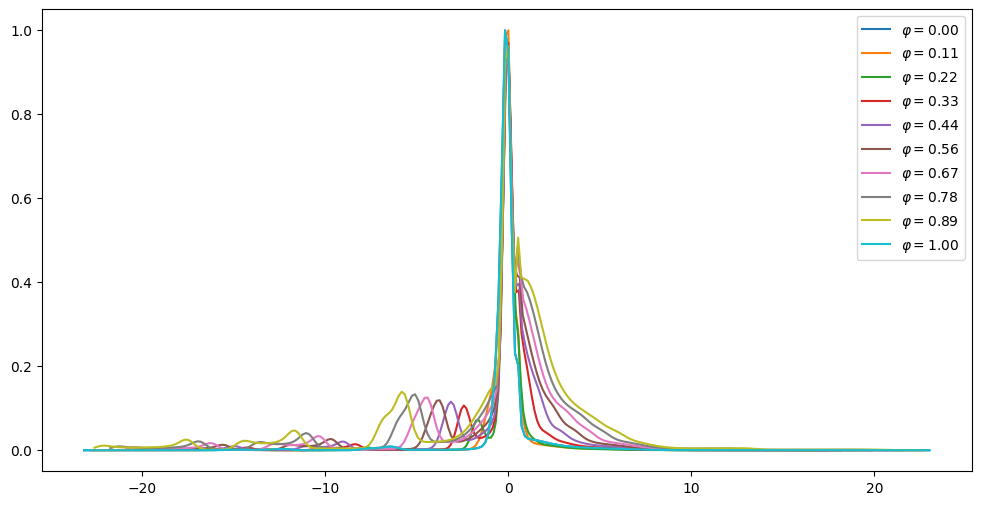

In [4]:
apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
# apep['phase'] = 0.6
shells = 3
model_func = gm.gui_funcs[shells-1]

fig, ax = plt.subplots(figsize=(12, 6))

for phase in np.linspace(0, 1, 10):
    apep['phase'] = phase
    particles, weights = model_func(apep)
    X, Y, H = gm.smooth_histogram2d(particles, weights, apep)
    # print(time.time() - t1)
    H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
#     gm.plot_spiral(X, Y, H)
    ax.plot(Y[:-1, 0], H[:, len(X[0, :])//2], label=fr'$\varphi = {phase:.2f}$')
ax.legend()

### Now to play with the data

In [20]:
from jax import jit
import jax.numpy as jnp
n = 600
@jit
def smooth_histogram2d(particles, weights, stardata):
    im_size = n
    
    x = particles[0, :]
    y = particles[1, :]
    
    xbound, ybound = jnp.max(jnp.abs(x)), jnp.max(jnp.abs(y))
    bound = jnp.max(jnp.array([xbound, ybound])) * (1. + 2. / im_size)
    
    xedges, yedges = jnp.linspace(-bound, bound, im_size+1), jnp.linspace(-bound, bound, im_size+1)
    return gm.smooth_histogram2d_base(particles, weights, stardata, xedges, yedges, im_size)
@jit
def smooth_histogram2d_w_bins(particles, weights, stardata, xbins, ybins):
    im_size = n
    return gm.smooth_histogram2d_base(particles, weights, stardata, xbins, ybins, im_size)

In [59]:
## directory = "Data\\JWST\\MAST_2024-07-29T2157\\JWST"
# # fname = glob(directory+"\\jw05842001001_03101_00001_mirimage\\*_cal.fits")[0]
# fname = glob(directory+"\\jw05842-o001_t001_miri_f2550w\\*_i2d.fits")[0]

# fname

# directory = "Data\\VLT"
# fnames = glob(directory + "\\*.fits")

apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
apep['period'] = 240
apep['phase'] = 0.4

particles, weights = model_func(apep)
X, Y, H = smooth_histogram2d(particles, weights, apep)
# print(time.time() - t1)
H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
xbins = X[0, :] * 1.5
ybins = Y[:, 0] * 1.5
# pscale = 1000 * (max(xbins) - min(xbins)) / len(xbins)

X, Y, H = smooth_histogram2d_w_bins(particles, weights, year_plume, xbins, ybins)
xbins = X[0, :]
ybins = Y[:, 0]
pscale = 1000 * (max(xbins) - min(xbins)) / len(xbins)








vlt_years = [2016, 2017, 2018, 2024]
vlt_data = {}
colours = {2016:"tab:blue", 2017:"tab:green", 2018:"tab:red", 2024:"tab:purple"}

shells = 1
model_func = gm.gui_funcs[shells-1]

for year in vlt_years:
    year_plume = apep.copy()
    year_plume['phase'] += (year - 2016) / year_plume['period']
    print(year_plume['phase'])
    particles, weights = model_func(year_plume)
    X, Y, H = smooth_histogram2d_w_bins(particles, weights, year_plume, xbins, ybins)
    # print(time.time() - t1)
    H = gm.add_stars(X[0, :], Y[:, 0], H, year_plume)
    H += np.random.normal(0, 0.005, H.shape)
    vlt_data[year] = H

0.4
0.4041666666666667
0.4083333333333334
0.43333333333333335


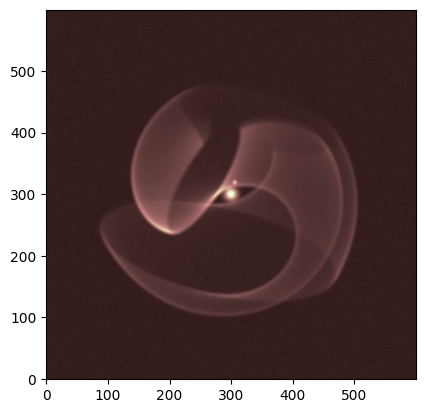

In [60]:
fig, ax = plt.subplots()
ax.imshow(vlt_data[2024], cmap='pink')
ax.invert_yaxis()

600


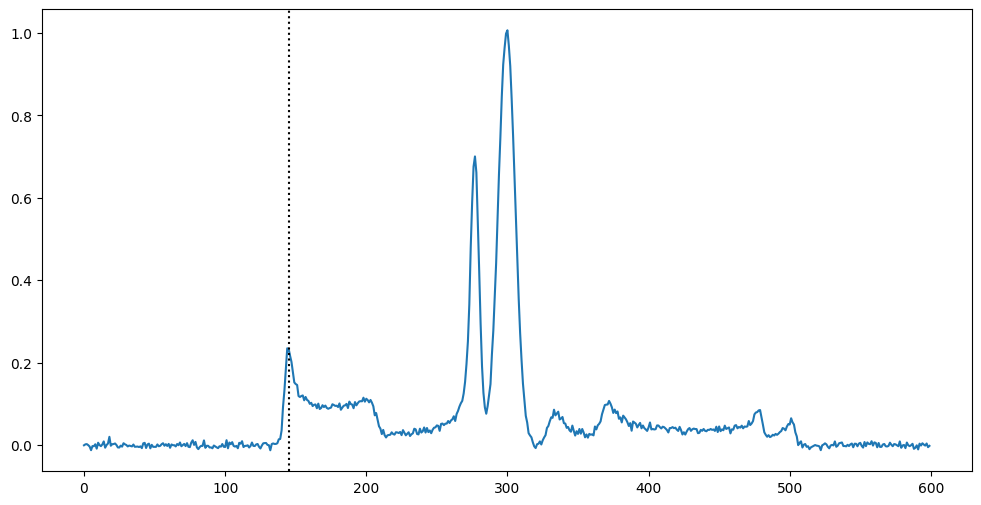

In [62]:
brightnesses = vlt_data[2024][::-1, 600//2]
brightnesses = vlt_data[2024][600//2, :]
print(len(brightnesses))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(brightnesses)
ax.axvline(145, ls=':', c='k')

[Text(0.5, 1.0, 'Left Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

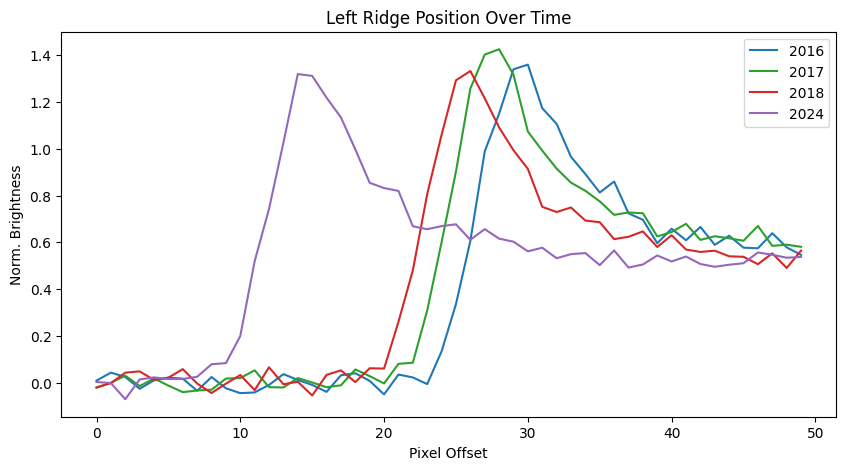

In [64]:
left_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][300, 130:180]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    left_ridges[key] = epoch_data / denumerator
    left_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(left_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Left Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

[Text(0.5, 1.0, 'Left Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

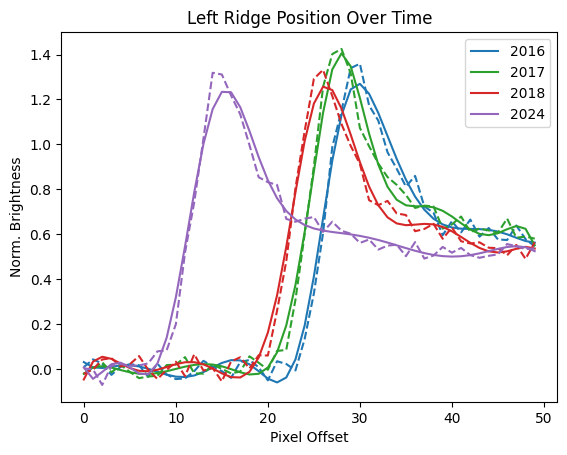

In [66]:
from scipy.interpolate import UnivariateSpline

left_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    left_ridge_splines[key] = UnivariateSpline(left_ridges['x'], left_ridges[key], k=5, s=0.1, ext=3)
    ax.plot(left_ridges['x'], left_ridge_splines[key](left_ridges['x']), c=colours[key], label=str(key))
    ax.plot(left_ridges['x'], left_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Left Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

-14.534556340870504


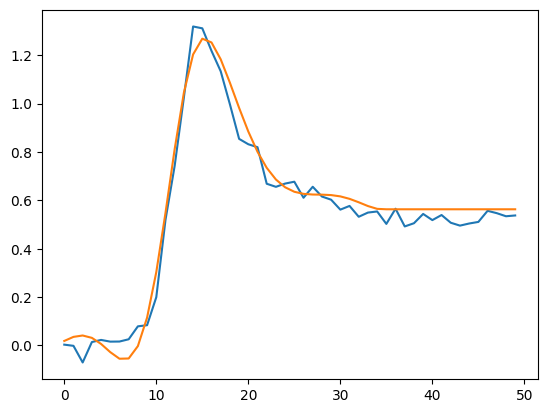

In [67]:
from scipy.optimize import least_squares, curve_fit


use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
#     if x - a < min_val or x - a > max_val:
#         return np.nan
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

test_data = left_ridges[2024]

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
[test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
print(test_shift)
fig, ax = plt.subplots()
ax.plot(left_ridges['x'], test_data)
ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))

[  0.          -1.879864    -3.60788614 -14.53455634]


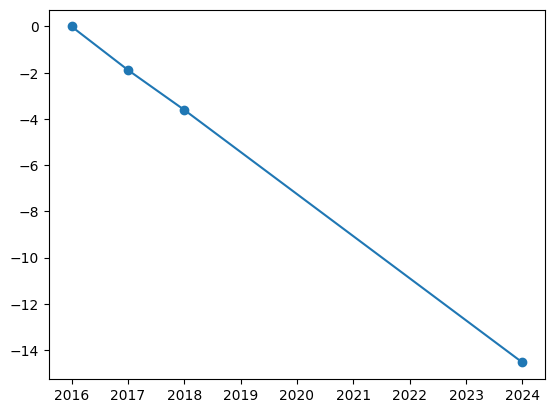

In [68]:
use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
left_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    [shift], _ = curve_fit(shifted_spline, ydata=left_ridges[year], xdata=left_ridges['x'], p0=(-10))
    left_ridge_shifts[i+1] = shift
    
print(left_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, left_ridge_shifts, marker='o')

Expansion of left ridge is 60.94 mas/yr
Hence the windspeed from the left edge is 693.9 km/s


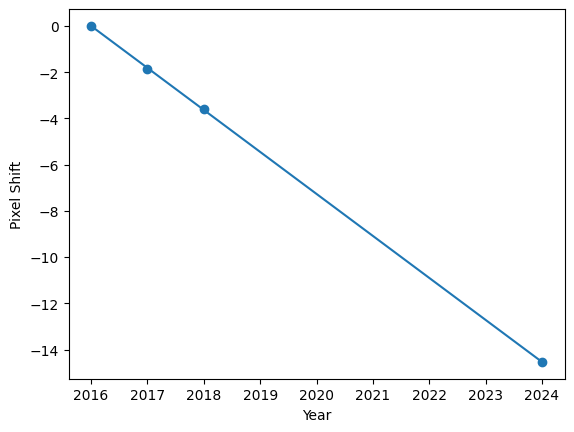

In [69]:
xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=left_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, left_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

left_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
left_ridge_windspeed = np.tan(np.deg2rad(left_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of left ridge is {left_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the left edge is {left_ridge_windspeed:.1f} km/s")

# Try again but with a more sophisticated fitting procedure
## Start with left ridge
The previous way included the spline even when out of bounds of the original data. This new way doesn't try to solve the least squares in that regime.

[-1.82259757]
[-3.61563089]
[-14.5000134]


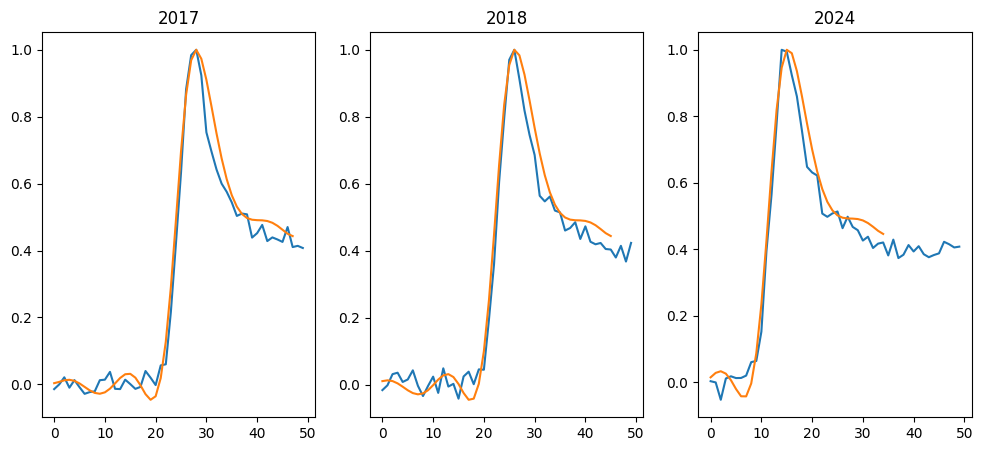

In [70]:
from scipy.optimize import least_squares, curve_fit, minimize


use_left_ridge_spline = left_ridge_splines[2016]
min_x, max_x = min(left_ridges['x']), max(left_ridges['x'])

def least_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    spl_y = use_left_ridge_spline(shifted_x[use_args])
    residuals = use_y / max(use_y) - spl_y / max(spl_y) # normalise the curves to a max of 1, then take residuals
    return np.sum(residuals**2) / (len(use_x) - 1)


fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, year in enumerate(vlt_years[1:]):
    test_data = left_ridges[year]
    result = minimize(least_sq_err, -14, args=(test_data, left_ridges['x']), method='Powell')
    test_shift = result.x
    print(test_shift)
    shifted_x = left_ridges['x'] - test_shift
    use_args = np.argwhere((shifted_x >= min_x) & (left_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

#     fig, ax = plt.subplots()
    spl_y = use_left_ridge_spline(shifted_x[use_args])
    axes[i].plot(left_ridges['x'], test_data / max(test_data))
    axes[i].plot(left_ridges['x'][use_args], spl_y / max(spl_y))
    axes[i].set_title(str(year))


[  0.          -1.82259757  -3.61563089 -14.5000134 ]


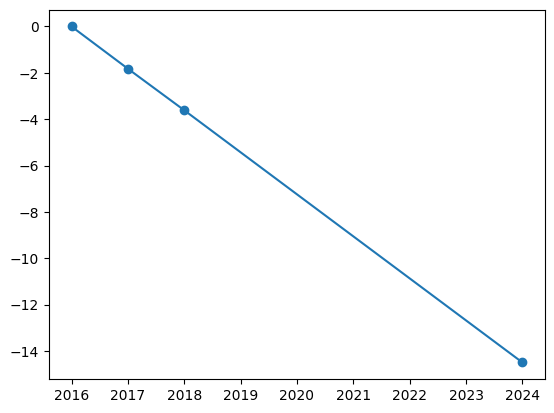

In [71]:
use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
left_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(least_sq_err, -14, args=(left_ridges[year], left_ridges['x']), method='Powell')
    left_ridge_shifts[i+1] = result.x[0]
    
print(left_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, left_ridge_shifts, marker='o')

Expansion of left ridge is 60.79 mas/yr
Hence the windspeed from the left edge is 692.2 km/s


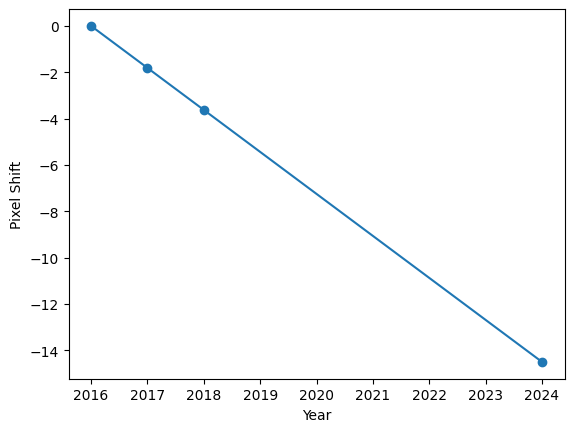

In [72]:
xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=left_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, left_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

left_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
left_ridge_windspeed = np.tan(np.deg2rad(left_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of left ridge is {left_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the left edge is {left_ridge_windspeed:.1f} km/s")

## Now for the right ridge.

[1.50295078]
[3.47738573]
[14.48857973]
[ 0.          1.50295078  3.47738573 14.48857973]
Expansion of right ridge is 60.45 mas/yr
Hence the windspeed from the right edge is 688.3 km/s


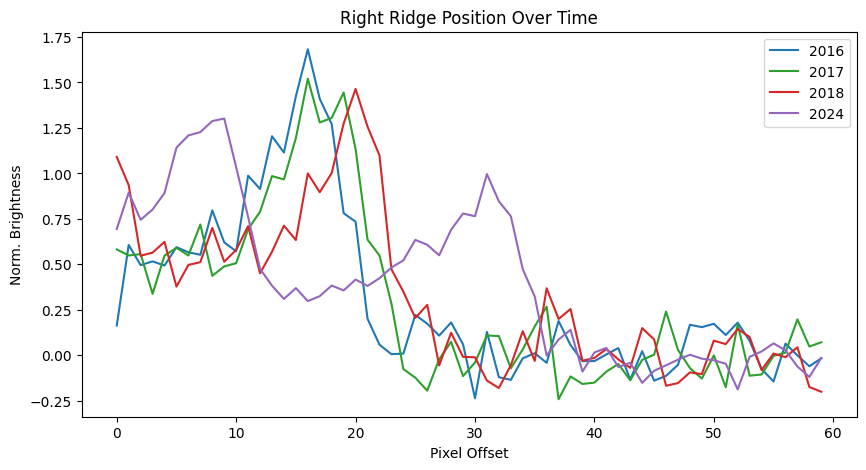

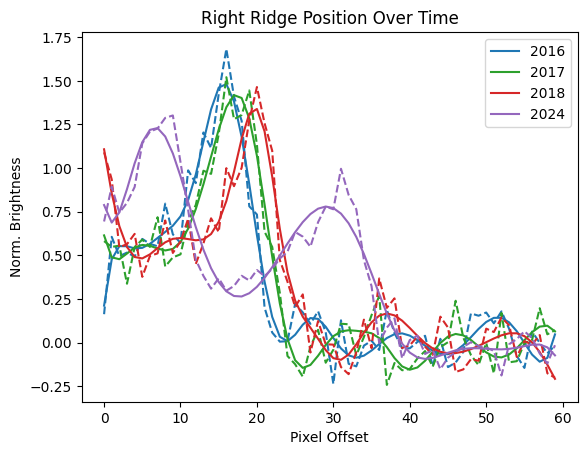

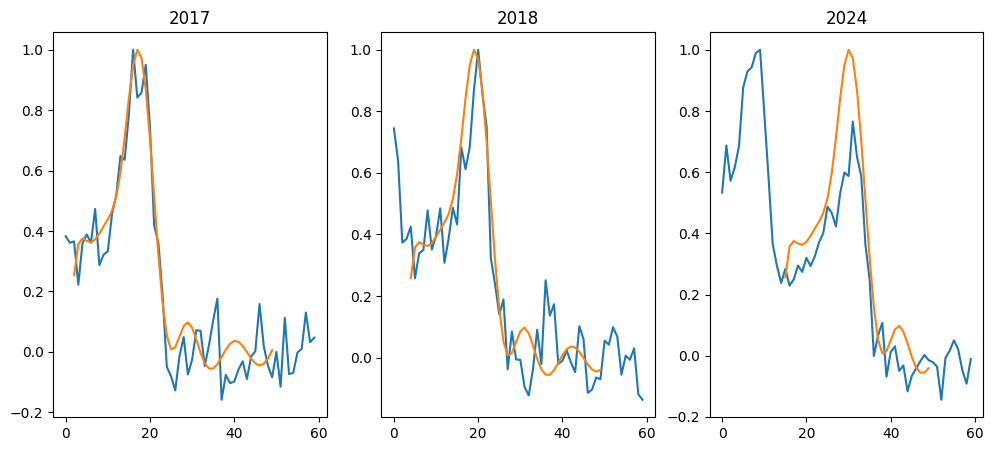

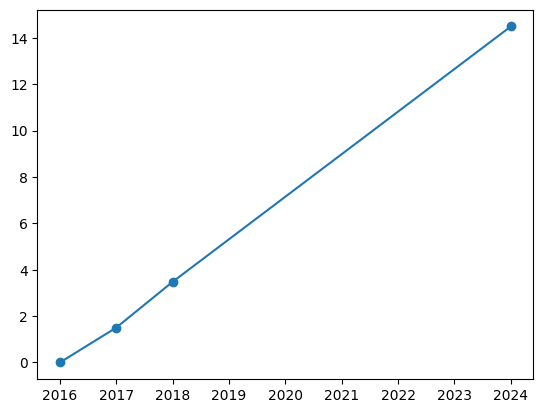

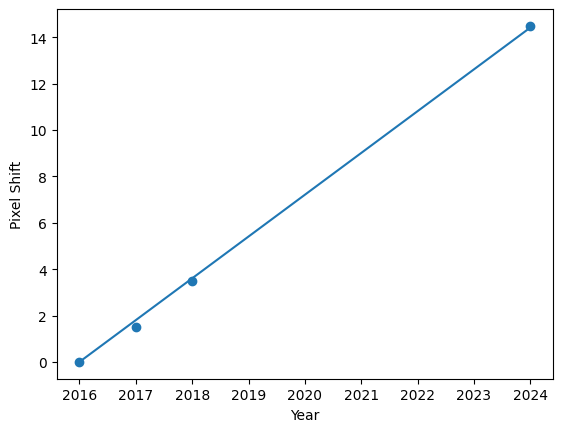

In [75]:
right_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][300, 470:530]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    right_ridges[key] = epoch_data / denumerator
    right_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(right_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Right Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.interpolate import UnivariateSpline

right_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    right_ridge_splines[key] = UnivariateSpline(right_ridges['x'], right_ridges[key], k=5, s=0.6, ext=3)
    ax.plot(right_ridges['x'], right_ridge_splines[key](right_ridges['x']), c=colours[key], label=str(key))
    ax.plot(right_ridges['x'], right_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Right Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.optimize import least_squares, curve_fit, minimize


use_right_ridge_spline = right_ridge_splines[2016]
min_x, max_x = min(right_ridges['x']), max(right_ridges['x'])

def least_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    spl_y = use_right_ridge_spline(shifted_x[use_args])
    residuals = use_y / max(use_y) - spl_y / max(spl_y) # normalise the curves to a max of 1, then take residuals
    return np.sum(residuals**2) / (len(use_x) - 1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, year in enumerate(vlt_years[1:]):
    test_data = right_ridges[year]
    result = minimize(least_sq_err, 5, args=(test_data, right_ridges['x']), method='Powell')
    test_shift = result.x
    print(test_shift)
    shifted_x = right_ridges['x'] - test_shift
    use_args = np.argwhere((shifted_x >= min_x) & (right_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

    spl_y = use_right_ridge_spline(shifted_x[use_args])
    axes[i].plot(right_ridges['x'], test_data / max(test_data))
    axes[i].plot(right_ridges['x'][use_args], spl_y / max(spl_y))
    axes[i].set_title(str(year))






def shifted_spline_sub(x, a):
    return use_right_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
right_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(least_sq_err, 5, args=(right_ridges[year], right_ridges['x']), method='Powell')
    right_ridge_shifts[i+1] = result.x[0]
    
print(right_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, right_ridge_shifts, marker='o')




xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=right_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, right_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

right_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
right_ridge_windspeed = np.tan(np.deg2rad(right_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of right ridge is {right_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the right edge is {right_ridge_windspeed:.1f} km/s")

## Finally the bottom ridge

600


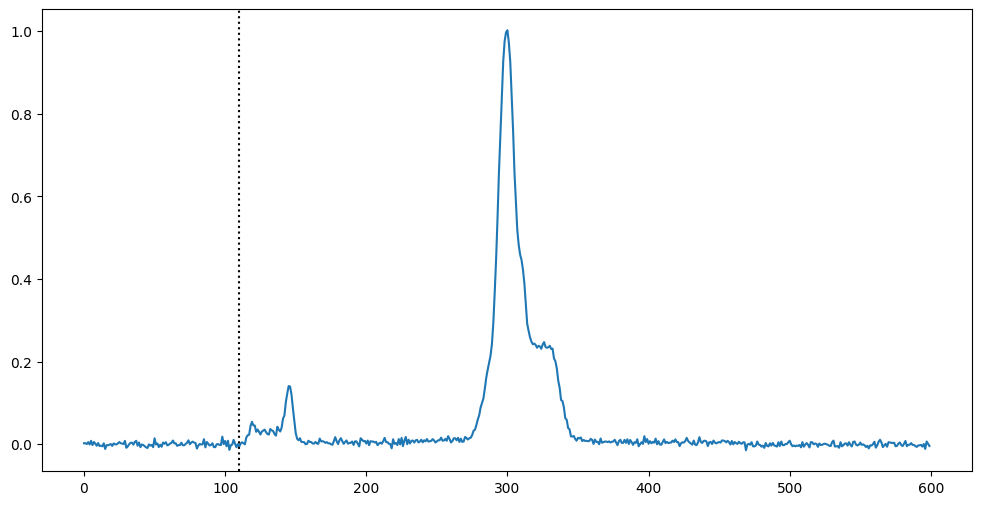

In [81]:
brightnesses = vlt_data[2016][:, 600//2]
print(len(brightnesses))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(brightnesses)
ax.axvline(110, ls=':', c='k')

[-1.61027139]
[-3.49999972]
[-14.49999951]
[  0.          -1.61027139  -3.49999972 -14.49999951]
Expansion of bottom ridge is 60.57 mas/yr
Hence the windspeed from the bottom edge is 689.7 km/s


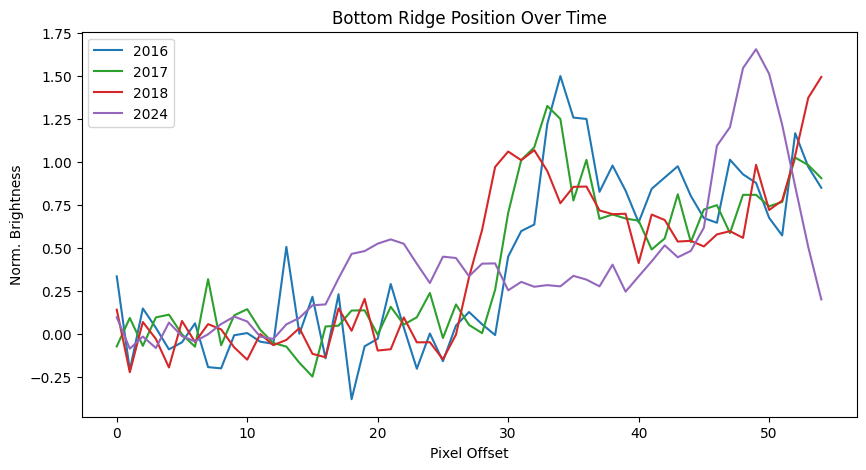

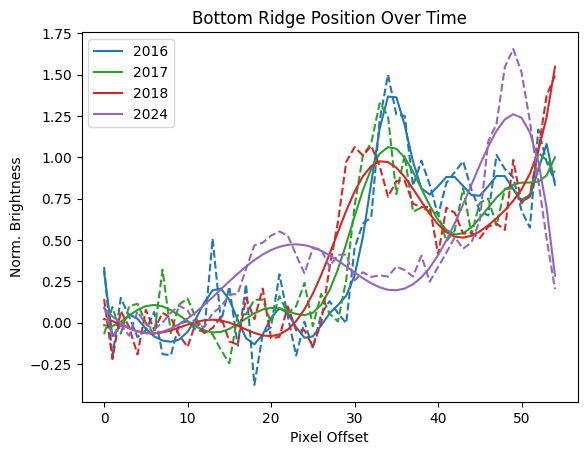

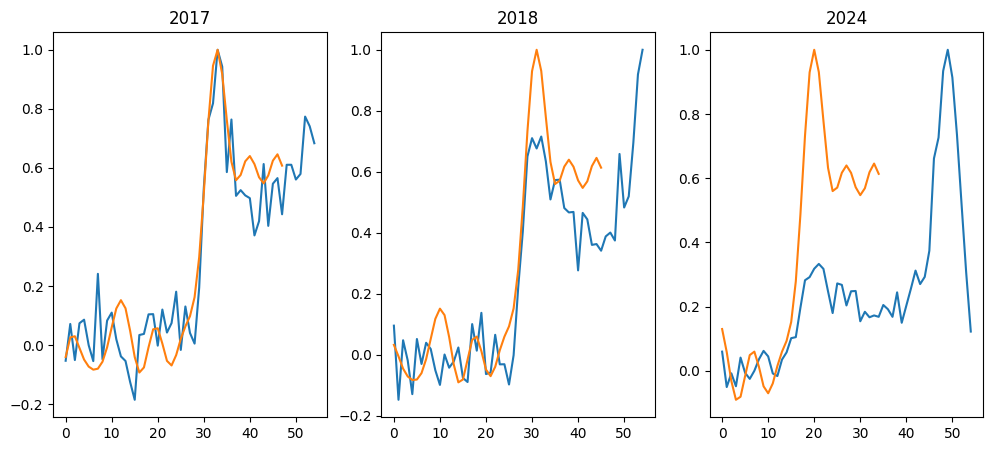

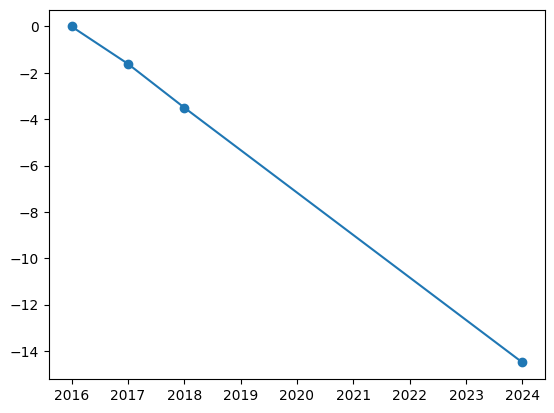

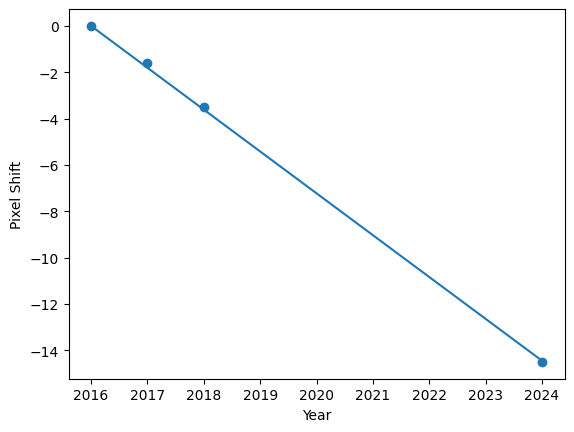

In [93]:
bottom_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][85:140, 300]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    bottom_ridges[key] = epoch_data / denumerator
    bottom_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(bottom_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Bottom Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.interpolate import UnivariateSpline

bottom_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    bottom_ridge_splines[key] = UnivariateSpline(bottom_ridges['x'], bottom_ridges[key], k=5, s=1, ext=3)
    ax.plot(bottom_ridges['x'], bottom_ridge_splines[key](bottom_ridges['x']), c=colours[key], label=str(key))
    ax.plot(bottom_ridges['x'], bottom_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Bottom Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')





from scipy.optimize import least_squares, curve_fit, minimize


use_bottom_ridge_spline = bottom_ridge_splines[2016]
min_x, max_x = min(bottom_ridges['x']), max(bottom_ridges['x'])

def least_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    spl_y = use_bottom_ridge_spline(shifted_x[use_args])
    residuals = use_y / max(use_y) - spl_y / max(spl_y) # normalise the curves to a max of 1, then take residuals
    return np.sum(residuals**2) / (len(use_x) - 1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, year in enumerate(vlt_years[1:]):
    test_data = bottom_ridges[year]

    # # result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
    # [test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
    # print(test_shift)
    # fig, ax = plt.subplots()
    # ax.plot(left_ridges['x'], test_data)
    # ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))
    result = minimize(least_sq_err, -12, args=(test_data, bottom_ridges['x']), method='Powell')
    test_shift = result.x
    print(test_shift)
    shifted_x = bottom_ridges['x'] - test_shift
    use_args = np.argwhere((shifted_x >= min_x) & (bottom_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

#     fig, ax = plt.subplots()
    spl_y = use_bottom_ridge_spline(shifted_x[use_args])
    axes[i].plot(bottom_ridges['x'], test_data / max(test_data))
    axes[i].plot(bottom_ridges['x'][use_args], spl_y / max(spl_y))
    axes[i].set_title(str(year))






def shifted_spline_sub(x, a):
    return use_bottom_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
bottom_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(least_sq_err, -12, args=(bottom_ridges[year], bottom_ridges['x']), method='Powell')
    bottom_ridge_shifts[i+1] = result.x[0]
    
print(bottom_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, bottom_ridge_shifts, marker='o')




xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=bottom_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, bottom_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

bottom_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
bottom_ridge_windspeed = np.tan(np.deg2rad(bottom_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of bottom ridge is {bottom_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the bottom edge is {bottom_ridge_windspeed:.1f} km/s")

## Now for JWST images

In [94]:
n = 1200
@jit
def smooth_histogram2d(particles, weights, stardata):
    im_size = n
    
    x = particles[0, :]
    y = particles[1, :]
    
    xbound, ybound = jnp.max(jnp.abs(x)), jnp.max(jnp.abs(y))
    bound = jnp.max(jnp.array([xbound, ybound])) * (1. + 2. / im_size)
    
    xedges, yedges = jnp.linspace(-bound, bound, im_size+1), jnp.linspace(-bound, bound, im_size+1)
    return gm.smooth_histogram2d_base(particles, weights, stardata, xedges, yedges, im_size)
@jit
def smooth_histogram2d_w_bins(particles, weights, stardata, xbins, ybins):
    im_size = n
    return gm.smooth_histogram2d_base(particles, weights, stardata, xbins, ybins, im_size)

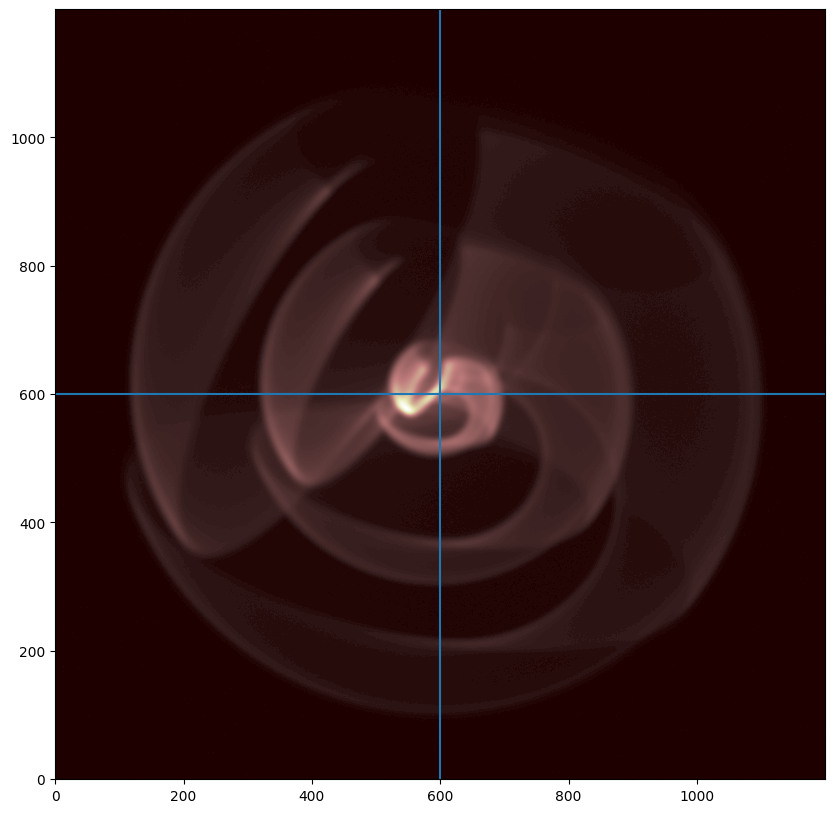

In [135]:
## directory = "Data\\JWST\\MAST_2024-07-29T2157\\JWST"
# # fname = glob(directory+"\\jw05842001001_03101_00001_mirimage\\*_cal.fits")[0]
# fname = glob(directory+"\\jw05842-o001_t001_miri_f2550w\\*_i2d.fits")[0]

# fname

# directory = "Data\\VLT"
# fnames = glob(directory + "\\*.fits")

apep = wrb.apep.copy()
apep['turn_on'] = -105
apep['turn_off'] = 140
apep['gradual_turn'] = 1
apep['period'] = 240
apep['phase'] = 0.4 + (2024 - 2016) / apep['period']
apep['sigma'] = 5

shells = 3
model_func = gm.gui_funcs[shells-1]

particles, weights = model_func(apep)
X, Y, H = smooth_histogram2d(particles, weights, apep)
# print(time.time() - t1)
H = gm.add_stars(X[0, :], Y[:, 0], H, apep)
xbins = X[0, :] * 1.2
ybins = Y[:, 0] * 1.2

X, Y, jwst_image = smooth_histogram2d_w_bins(particles, weights, apep, xbins, ybins)
jwst_xbins = X[0, :]
jwst_ybins = Y[:, 0]
jwst_pscale = 1000 * (max(jwst_xbins) - min(jwst_xbins)) / len(jwst_xbins)


jwst_image = 900 + 3e3 * abs(jwst_image)**(0.9)
jwst_image += np.random.normal(0, 2, jwst_image.shape)







fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(jwst_image, cmap='pink')
ax.invert_yaxis()

jwst_center_x = 600
jwst_center_y = 600
ax.axvline(jwst_center_x)
ax.axhline(jwst_center_y)

Period estimate from bottom ridge shell separation and VISIR expansion is 242.65 years.


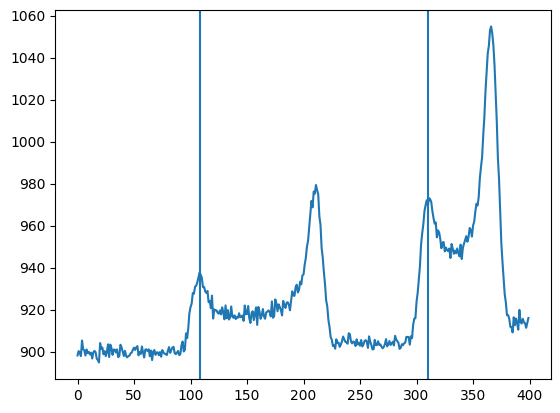

In [139]:
fig, ax = plt.subplots()
brightness_bottom = jwst_image[:, jwst_center_x][0:400]
ax.plot(np.arange(len(brightness_bottom)), brightness_bottom)

first_peak_bottom = np.argmax(brightness_bottom[:100])
first_peak_bottom = 65
first_peak_bottom = 108
second_peak_bottom = np.argmax(brightness_bottom)
second_peak_bottom = 310

ax.axvline(first_peak_bottom)
ax.axvline(second_peak_bottom)

delta_pixels_bottom = second_peak_bottom - first_peak_bottom

delta_angle_bottom = delta_pixels_bottom * jwst_pscale  # mas

delta_year_bottom = delta_angle_bottom / bottom_ridge_expansion
print(f"Period estimate from bottom ridge shell separation and VISIR expansion is {delta_year_bottom:.2f} years.")

Period estimate from left ridge shell separation and VISIR expansion is 242.98 years.


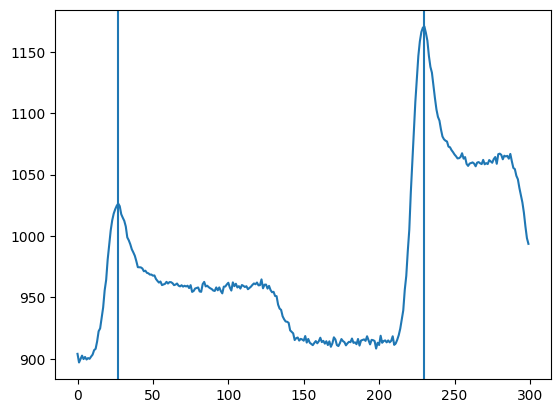

In [146]:
fig, ax = plt.subplots()
brightness_left = jwst_image[jwst_center_y, :][100:400]
ax.plot(np.arange(len(brightness_left)), brightness_left)

first_peak_left = np.argmax(brightness_left[:100])
first_peak_left = 27
second_peak_left = np.argmax(brightness_left)
second_peak_left = 230

ax.axvline(first_peak_left)
ax.axvline(second_peak_left)

delta_pixel_left = second_peak_left - first_peak_left

delta_angle_left = delta_pixel_left * jwst_pscale  # mas

delta_year_left = delta_angle_left / left_ridge_expansion
print(f"Period estimate from left ridge shell separation and VISIR expansion is {delta_year_left:.2f} years.")

Period estimate from right ridge shell separation and VISIR expansion is 245.53 years.


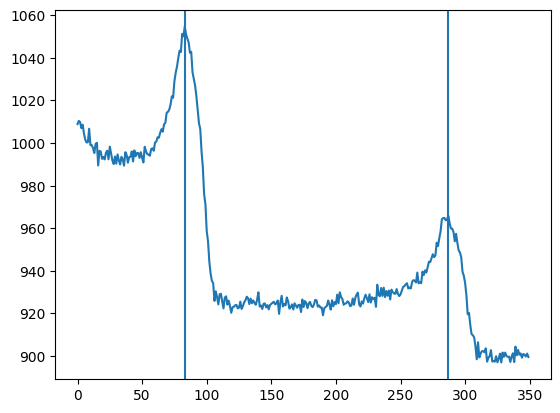

In [148]:
fig, ax = plt.subplots()
brightness_right = jwst_image[jwst_center_y, :][800:1150]
ax.plot(np.arange(len(brightness_right)), brightness_right)

first_peak_right = np.argmax(brightness_right)
second_peak_right = len(brightness_right) - 100 + np.argmax(brightness_right[-100:])
# second_peak_right = 205

ax.axvline(first_peak_right)
ax.axvline(second_peak_right)

delta_pixel_right = second_peak_right - first_peak_right

delta_angle_right = delta_pixel_right * jwst_pscale  # mas

delta_year_right = delta_angle_right / right_ridge_expansion
print(f"Period estimate from right ridge shell separation and VISIR expansion is {delta_year_right:.2f} years.")